# **Python beats pundit: Election result predicted using scraped tweets and sentiment analysis. Sorry, pollsters!**

# Installing the neccessary libraries 

In [1]:
!pip install snscrape
!pip install textblob
!pip install nltk
!pip install wordcloud
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 KB 3.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 KB 2.7 MB/s eta 0:00:00


# Importing the libraries

In [2]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords') #run once and comment it out to avoid it downloading multiple times
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Setting up the query.

In [3]:
# comment it out once you have gathered your data 
# to avoid running out of wait time gather the data per month
#query = "(Peter Obi OR Tinubu OR Atiku OR #PeterObiForPresident2023 OR #TinubuForPresident2023 OR #AtikuForPresident2023 OR #BAT2023 OR #Obi2023 OR #Atiku2023 OR #OBIdient OR #Atikulated OR Batified OR PDP OR APC OR LP OR LABOUR PARTY) since:2022-12-01 until:2023-02-15"
#tweets = []
#for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
  #  if i>20000:
#         break
#     else:
#         tweets.append([tweet.date, tweet.id, tweet.url, tweet.user.username, tweet.sourceLabel, tweet.user.location, tweet.content, tweet.likeCount, tweet.retweetCount])
# df = pd.DataFrame(tweets, columns = ['Date', 'ID', 'url', 'username', 'source', 'location', 'tweet', 'num_of_likes', 'num_of_retweet'])
# df.to_csv('sentiment.csv', mode = 'a')

Taking a sneak peek at the data we have gathered by using the code below

In [4]:
df =  pd.read_csv('sentiment.csv', encoding = 'unicode_escape')
df.head(2)

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet
0,0,2023-02-14 23:57:58+00:00,1625645555069190144,https://twitter.com/Chiglobaltrade/status/1625...,Chiglobaltrade,Twitter for Android,Lagos Nigeria,I am not voting Top to Bottom. There are incom...,0,0
1,1,2023-02-14 23:57:20+00:00,1625645396226633729,https://twitter.com/AimerAljamie/status/162564...,AimerAljamie,Twitter for Android,NaN,@Aminaruk @adamugarba Book haram leaders are t...,0,0


# data wrangling

In [5]:
df.location.isna().sum()
df['location'] = df['location'].fillna('Unknown')

# Data Preprocessing: How about "Cleaning Up Tweet Trash?

In [6]:
#download this Open Multilingual Wordnet-1.4
#nltk.download('omw-1.4')

# creating a list of English stop words and emojis

In [7]:
eng_stop_words = list(stopwords.words('english'))

emoji = list(UNICODE_EMOJI.keys())

# creating a tweet preprocessing function 

In [8]:
# function for preprocessing tweet in preparation for sentiment analysis
def ProcessedTweets(text):
    #changing tweet text to small letters
    text = text.lower()
    # Removing @ and links 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    # removing repeating characters
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    # removing punctuation and numbers
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

# Creating a column for preprocessed tweets

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [16]:
# Generate a new column called 'Processed Tweets' by applying preprocessed tweets function to the 'Tweet' column.
df['Processed_Tweets'] = df['tweet'].apply(ProcessedTweets)

df.head(5)

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet,Processed_Tweets
0,0,2023-02-14 23:57:58+00:00,1625645555069190144,https://twitter.com/Chiglobaltrade/status/1625...,Chiglobaltrade,Twitter for Android,Lagos Nigeria,I am not voting Top to Bottom. There are incom...,0,0,voting top bottom incompetent candidate every ...
1,1,2023-02-14 23:57:20+00:00,1625645396226633729,https://twitter.com/AimerAljamie/status/162564...,AimerAljamie,Twitter for Android,Unknown,@Aminaruk @adamugarba Book haram leaders are t...,0,0,book haram leader trying distribute across dif...
2,2,2023-02-14 23:57:15+00:00,1625645376366682113,https://twitter.com/SadoPeter2/status/16256453...,SadoPeter2,Twitter for iPhone,Edo boy,@adamugarba Make I send my opay make you do tr...,0,0,make send opay make transfer case want buy vot...
3,3,2023-02-14 23:54:08+00:00,1625644593969524738,https://twitter.com/StoolBreaker/status/162564...,StoolBreaker,Twitter for Android,Nigeria,Acid test for Military and Police!\nBe Lagos-r...,0,0,acid test military police lagosready tinubu as...
4,4,2023-02-14 23:50:53+00:00,1625643774994010114,https://twitter.com/IAmMooree/status/162564377...,IAmMooree,Twitter for iPhone,Unknown,weed out bad eggs in the legislature (I myself...,1,0,weed bad egg legislature project dedicated foc...


# Replacing incorrect/ nonsensical words in processed tweet

In [17]:
#another data wrangling process
#replacing some words in the processed tweet
df['Processed_Tweets'] = df['tweet'].replace(to_replace ='parties', value = 'party')
df['Processed_Tweets'] = df['tweet'].replace(to_replace ='Labor party', value = 'Labour party')

# Extracting information on the Nigerian political parties and their top candidates

In [18]:
#another data wrangling process
# extracting the parties: apc, pdp, labour party and the 3 top candidate name into new columns
def extract_apc(n):
  n = str(n)
  resp = n.lower().find("apc")
  if resp != -1:
    return "APC"
  else:
    return None

def extract_pdp(n):
  n = str(n)
  resp = n.lower().find("pdp")
  if resp != -1:
    return "PDP"
  else:
    return None

def extract_labour(n):
  n = str(n)
  resp = n.lower().find("labour party")
  if resp != -1:
    return "Labour Party"
  else:
    return None

def extract_obi(n):
  n = str(n)
  resp = n.lower().find("obi")
  if resp != -1:
    return "Peter Obi"
  else:
    return None

def extract_atiku(n):
  n = str(n)
  resp = n.lower().find("atiku")
  if resp != -1:
    return "Atiku"
  else:
    return None

def extract_tinubu(n):
  n = str(n)
  resp = n.lower().find("tinubu")
  if resp != -1:
    return "Tinubu"
  else:
    return None

# Extracting and aggregating tweet relating to each of the political parties   

In [19]:
#applying the function
df['Obi'] = df['tweet'].apply(extract_obi) 
df['labour'] = df['tweet'].apply(extract_labour) 
df['pdp'] = df['tweet'].apply(extract_pdp) 
df['apc'] = df['tweet'].apply(extract_apc) 
df['atiku'] = df['tweet'].apply(extract_atiku) 
df['tinubu'] = df['tweet'].apply(extract_tinubu)

# Replacing empty values with Empty

In [20]:
#another data wrangling process
# replacing empty values with Empty
df['Obi'] = df['Obi'].fillna('Empty')
df['labour'] = df['labour'].fillna('Empty')
df['pdp'] = df['pdp'].fillna('Empty')
df['apc'] = df['apc'].fillna('Empty')
df['atiku'] = df['atiku'].fillna('Empty')
df['tinubu'] = df['tinubu'].fillna('Empty')

# convert the tweet text into a string separate with " "

In [21]:
#another data wrangling process
# convert the tweet text into a string separate with " "
tweets_string = df['Processed_Tweets'].tolist()
tweets_string = " ".join(tweets_string)

# calculate the polarity

In [22]:
# Function for polarity score
def polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [23]:
# Function to get sentiment type
#setting the conditions
def sentimenttextblob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [24]:
#using the functions to get the polarity and sentiment
df['Polarity'] = df['Processed_Tweets'].apply(polarity)
df['Sentiment'] = df['Polarity'].apply(sentimenttextblob)
sent = df['Sentiment'].value_counts()
sent

Positive    9559
Neutral     6890
Negative    3552
Name: Sentiment, dtype: int64

# plotting bar chart for the Sentiment


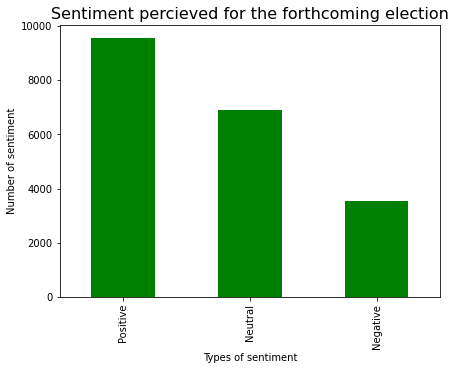

In [25]:
plt.subplot(1,2,1)
sent.plot(kind='bar', color=['green'], figsize=(15,5))
plt.title('Sentiment percieved for the forthcoming election', fontsize=16)
plt.xlabel('Types of sentiment')
plt.ylabel('Number of sentiment');

Visualization of the most talked-about words in a word cloud

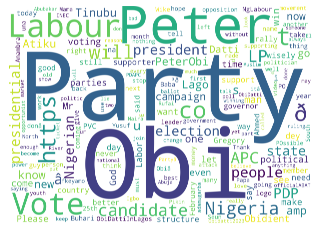

In [26]:
# Displaying the most talked about word in a word cloud 
# some stop words were still evident but was removed during visualization on Power BI
# Instantiate the Twitter word cloud object
w_cloud = WordCloud(collocations = False,max_words=200, background_color = 'white', width = 7000, height = 5000).generate(tweets_string)

# Display the generated Word Cloud
plt.imshow(w_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# masking the word cloud into Nigeria's flag colour

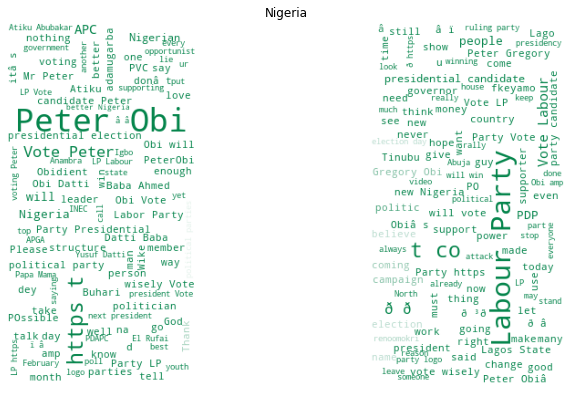

In [27]:
# masking the word cloud into Nigeria's flag colour

#Create the mask
colosseum_mask = np.array(Image.open('Nigeria Flag.jpg'))

#Grab the mask colors
colors = ImageColorGenerator(colosseum_mask)

#Instantiate the wordcloud using color_func argument
cloud = WordCloud(mask=colosseum_mask,
                  background_color='white',
                  color_func=colors).generate_from_text(tweets_string)

#Plot the wordcloud
plt.figure(figsize=(10,8))
plt.imshow(cloud)
plt.axis('off')
plt.title('Nigeria')
plt.show()

In [33]:
# saving the file used for further used in power bi
df.to_csv('final_tweet.csv')